In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
def generate_xor_dataset(size):
    centers = [[-3.5, 3.5], [-3.5, -3.5], [3.5, -3.5], [3.5, 3.5]]
    X, _ = make_blobs(n_samples = size, centers = centers, n_features = 2, random_state = 13, cluster_std = 1.8)
    X = torch.FloatTensor(X)
    y = (X[:, 0] > 0) != (X[:, 1] > 0)
    return X, y.float().view(-1, 1)

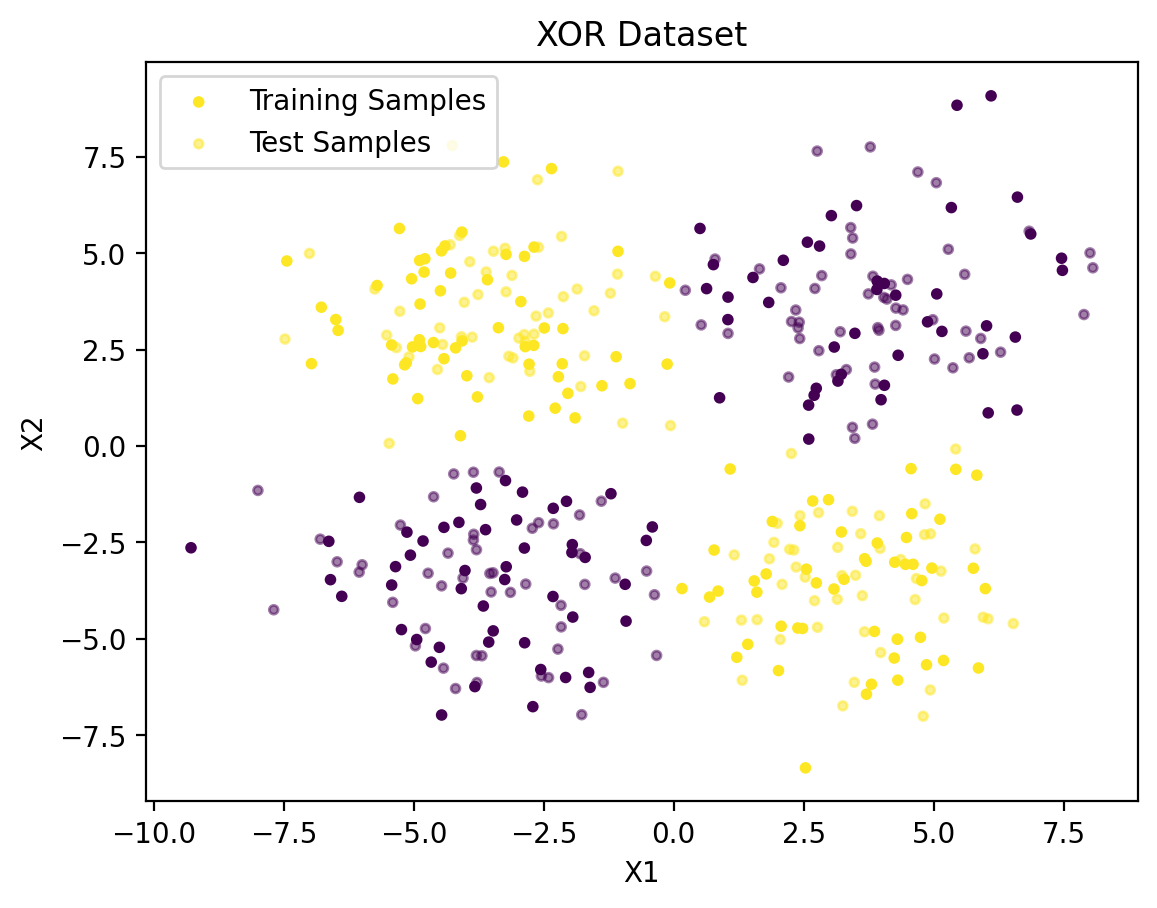

In [3]:
X, y = generate_xor_dataset(400)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5)
plt.scatter(X_train[:, 0], X_train[:, 1], c = y_train, cmap = "viridis", s = 10, label = "Training Samples")
plt.scatter(X_test[:, 0], X_test[:, 1], c = y_test, cmap = "viridis", s = 10, label = "Test Samples", alpha = 0.5)
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("XOR Dataset")
plt.legend()
plt.show()


In [35]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([200, 2]),
 torch.Size([200, 2]),
 torch.Size([200, 1]),
 torch.Size([200, 1]))

## MLP

In [50]:
class MLP(nn.Module):
  def __init__(self, hidden_layer1, hidden_layer2):
    super().__init__()
    self.lin1 = nn.Linear(2, hidden_layer1)
    self.lin2 = nn.Linear(hidden_layer1, hidden_layer2)
    self.lin3 = nn.Linear(hidden_layer2, 1)

  def forward(self, x):
    x = torch.relu(self.lin1(x))
    x = torch.relu(self.lin2(x))
    logits = self.lin3(x)

    return logits

In [51]:
model = MLP(hidden_layer1 = 10, hidden_layer2 = 8)

In [52]:
for param_name, param in model.named_parameters():
    print(param_name, param.shape)

lin1.weight torch.Size([10, 2])
lin1.bias torch.Size([10])
lin2.weight torch.Size([8, 10])
lin2.bias torch.Size([8])
lin3.weight torch.Size([1, 8])
lin3.bias torch.Size([1])


## Model Training w/ No Regularization


In [54]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True)

for epoch in range(10000):
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        logits = model(inputs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch + 1}:  Loss: {epoch_loss}")

Epoch 1000:  Loss: 6.621722682861478e-05
Epoch 2000:  Loss: 1.7145688551473931e-06
Epoch 3000:  Loss: 6.507821380198817e-08
Epoch 4000:  Loss: 1.9500747125026203e-07
Epoch 5000:  Loss: 2.3387509072238444e-08
Epoch 6000:  Loss: 1.5393876649584726e-08
Epoch 7000:  Loss: 1.2992310975869669e-08
Epoch 8000:  Loss: 1.539801594166842e-08
Epoch 9000:  Loss: 2.0721863387101232e-06
Epoch 10000:  Loss: 4.2583034241618275e-08


In [55]:
model.eval()

with torch.no_grad():
    logits = model(X_test)
    predictions = (logits > 0).float()
    accuracy = (predictions == y_test).sum().item() / y_test.size(0)
    print(f"Test Accuracy: {accuracy:.7f}")

Test Accuracy: 0.9850000


In [56]:
def plot_decision_boundary(X_train, X_test, y_train, y_test, model, title):
    X = torch.cat([X_train, X_test], dim = 0).numpy()
    y = torch.cat([y_train, y_test], dim = 0).numpy()
    
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    Z = model(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]))
    
    Z = (Z > 0).float().numpy().reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, cmap = plt.cm.Paired, alpha = 0.4)
    
    plt.scatter(X_train[:, 0], X_train[:, 1], c = y_train, cmap = "viridis", s = 10)
    plt.scatter(X_test[:, 0], X_test[:, 1], c = y_test, cmap = "viridis", s = 10, alpha = 0.5)
    
    patches = [
        mpatches.Patch(color="yellow", label="Class 1"),
        mpatches.Patch(color="darkblue", label="Class 2"),
        mpatches.Patch(color="darksalmon", label="Predict Class 1"),
        mpatches.Patch(color="lightblue", label="Predict Class 2"),
    ]
    plt.legend(
        handles=patches, loc="upper center", bbox_to_anchor=(0.5, 1.25),
        ncol=2, fancybox=True, shadow=True
    )
    plt.title(title)
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.show()

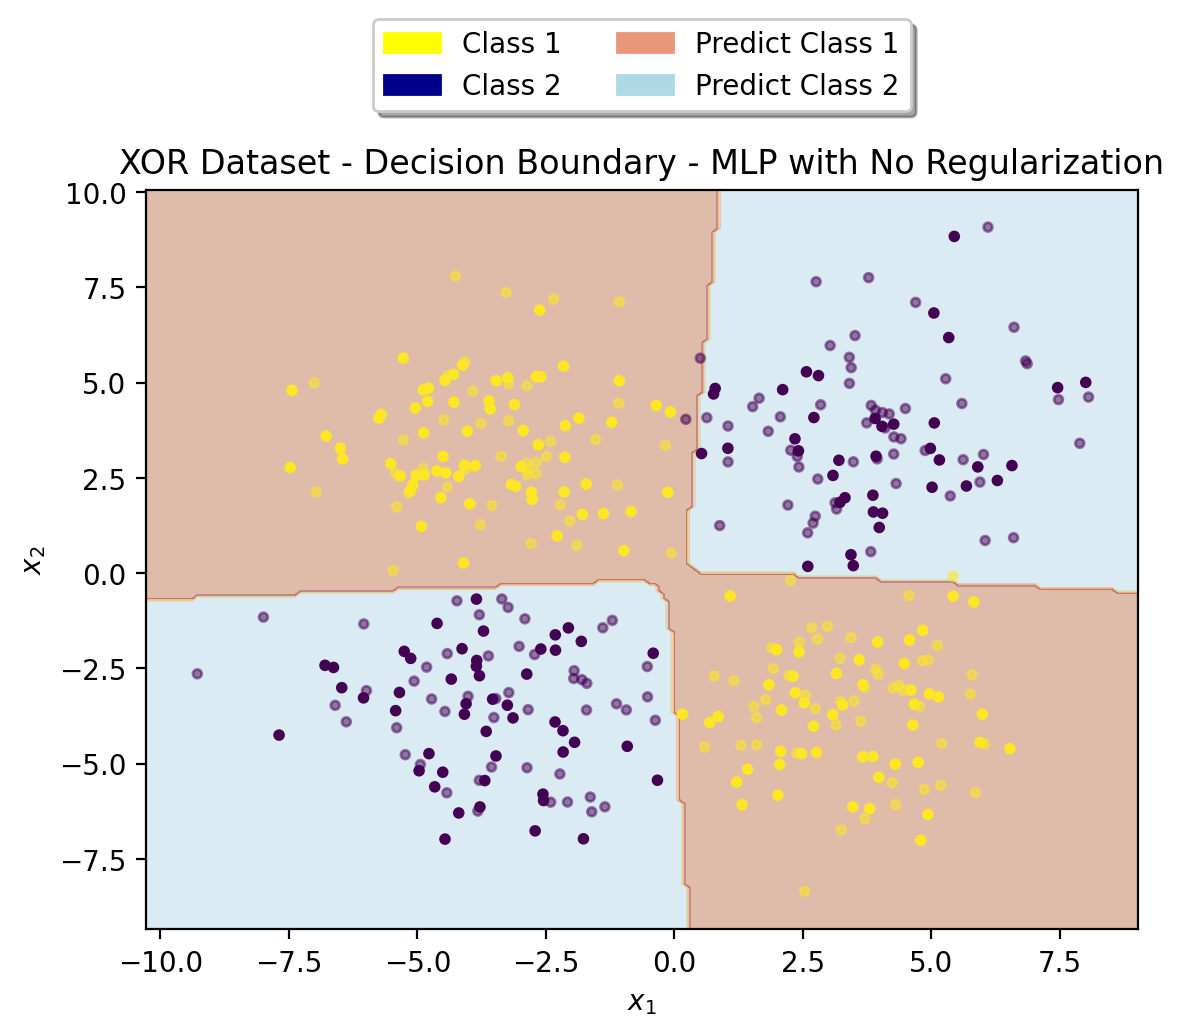

In [57]:

plot_decision_boundary(X_train, X_test, y_train, y_test, model, "XOR Dataset - Decision Boundary - MLP with No Regularization")

## MLP w/ L1 regularization

In [64]:
model = MLP(hidden_layer1 = 10, hidden_layer2 = 8)

In [65]:
for param_name, param in model.named_parameters():
    print(param_name, param.shape)

lin1.weight torch.Size([10, 2])
lin1.bias torch.Size([10])
lin2.weight torch.Size([8, 10])
lin2.bias torch.Size([8])
lin3.weight torch.Size([1, 8])
lin3.bias torch.Size([1])


## MLP w/ L1 regularization

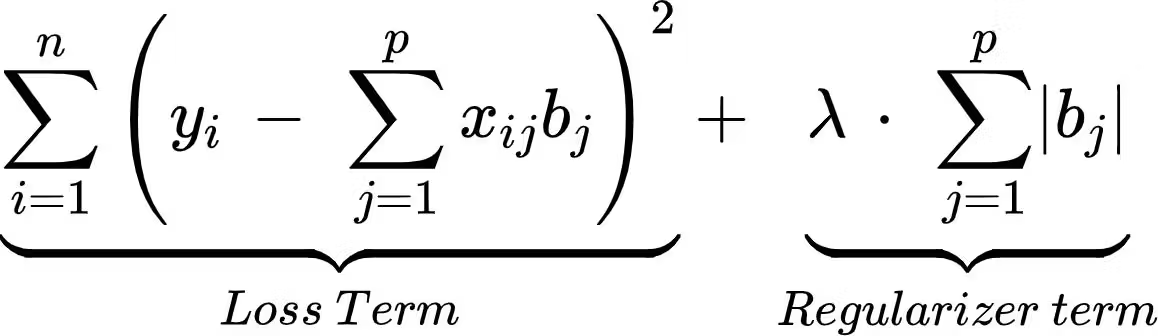


In [66]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)

# L1 Regularization Penalty Coefficient
beta = 0.001

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True)

for epoch in range(10000):
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        logits = model(inputs)
        loss = criterion(logits, labels)
        
        l1_regularization = 0.0
        for param in model.parameters():
            l1_regularization += torch.norm(param, 1)
        loss += beta * l1_regularization
        
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch + 1}: Loss: {epoch_loss}")

Epoch 1000: Loss: 0.022040415023054396
Epoch 2000: Loss: 0.021984109388930455
Epoch 3000: Loss: 0.022609092827354158
Epoch 4000: Loss: 0.022146278992295265
Epoch 5000: Loss: 0.021595955161111697
Epoch 6000: Loss: 0.021709608446274484
Epoch 7000: Loss: 0.021695769525000026
Epoch 8000: Loss: 0.02170619581426893
Epoch 9000: Loss: 0.021717766299843788
Epoch 10000: Loss: 0.022240340443594114


In [67]:
model.eval()

with torch.no_grad():
    logits = model(X_test)
    predictions = (logits > 0).float()
    accuracy = (predictions == y_test).sum().item() / y_test.size(0)
    print(f"Test Accuracy: {accuracy:.7f}")

Test Accuracy: 0.9900000


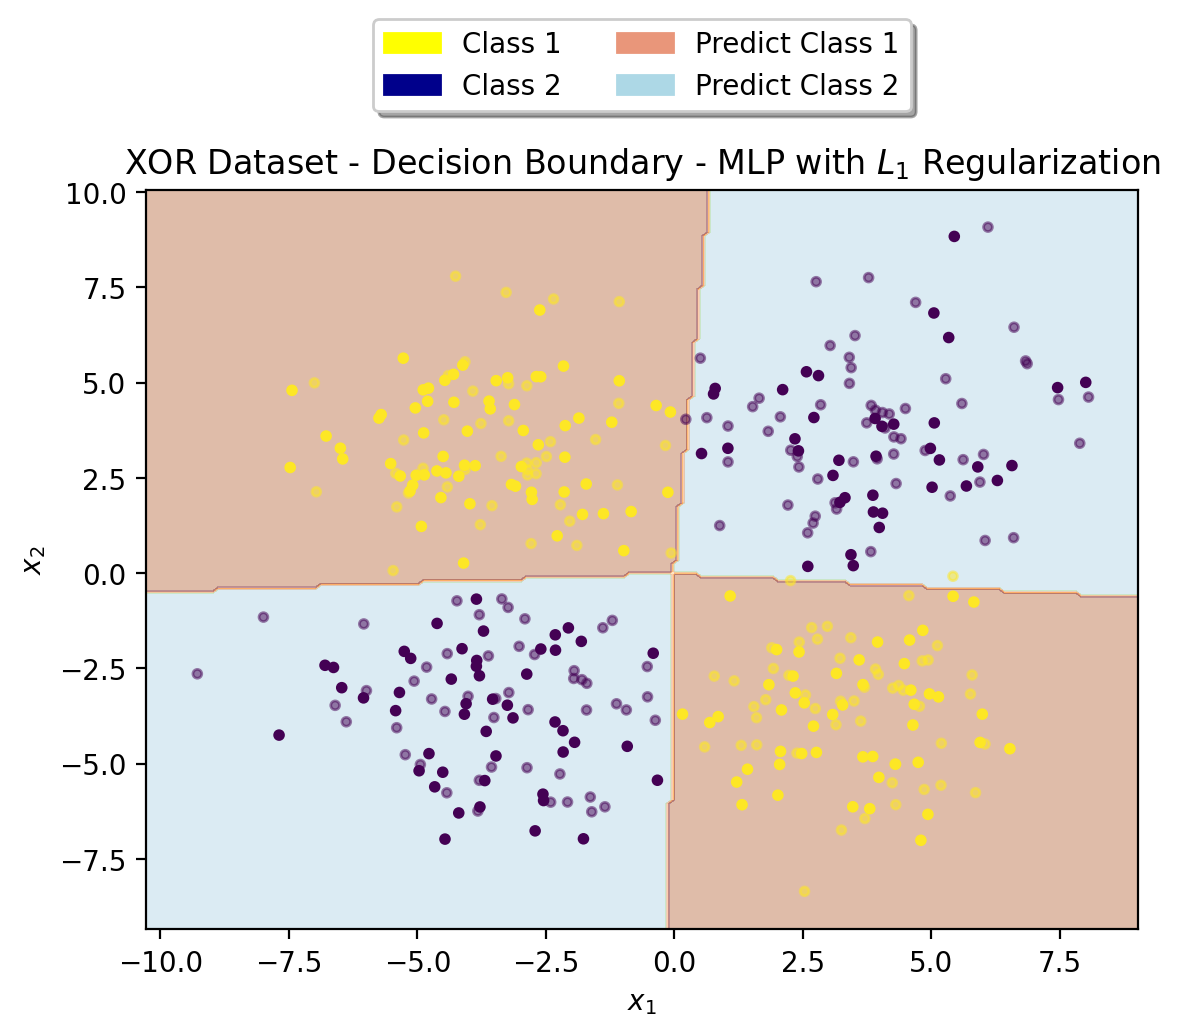

In [68]:
plot_decision_boundary(X_train, X_test, y_train, y_test, model, "XOR Dataset - Decision Boundary - MLP with $L_1$ Regularization")

## MLP w/ L2 regularization

In [74]:
model = MLP(hidden_layer1 = 10, hidden_layer2 = 8)

In [75]:
for param_name, param in model.named_parameters():
    print(param_name, param.shape)

lin1.weight torch.Size([10, 2])
lin1.bias torch.Size([10])
lin2.weight torch.Size([8, 10])
lin2.bias torch.Size([8])
lin3.weight torch.Size([1, 8])
lin3.bias torch.Size([1])


## Model Training w/ $L_2$ Regularization
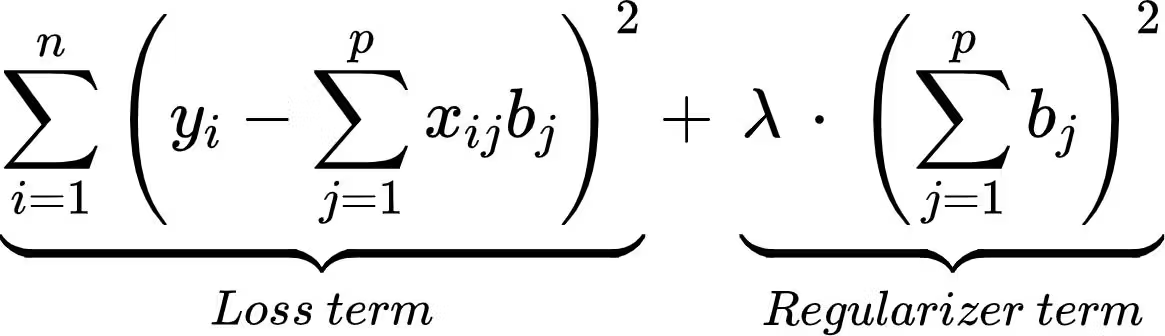

In [76]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)

# L2 Regularization Penalty Coefficient
beta = 0.001

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True)

for epoch in range(10000):
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        logits = model(inputs)
        loss = criterion(logits, labels)
        
        l2_regularization = 0.0
        for param in model.parameters():
            l2_regularization += torch.norm(param, 2)
        loss += beta * l2_regularization
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch + 1}: Loss: {epoch_loss} ")

Epoch 1000:  Loss: 0.011307141610554286 
Epoch 2000:  Loss: 0.011243521901113647 
Epoch 3000:  Loss: 0.011179705150425434 
Epoch 4000:  Loss: 0.011666794174483843 
Epoch 5000:  Loss: 0.011202249942081315 
Epoch 6000:  Loss: 0.011172174742179257 
Epoch 7000:  Loss: 0.01114530289279563 
Epoch 8000:  Loss: 0.011371317319571972 
Epoch 9000:  Loss: 0.011115805645074164 
Epoch 10000:  Loss: 0.013521271092551095 


In [77]:
model.eval()

with torch.no_grad():
    logits = model(X_test)
    predictions = (logits > 0).float()
    accuracy = (predictions == y_test).sum().item() / y_test.size(0)
    print(f"Test Accuracy: {accuracy:.7f}")

Test Accuracy: 0.9900000


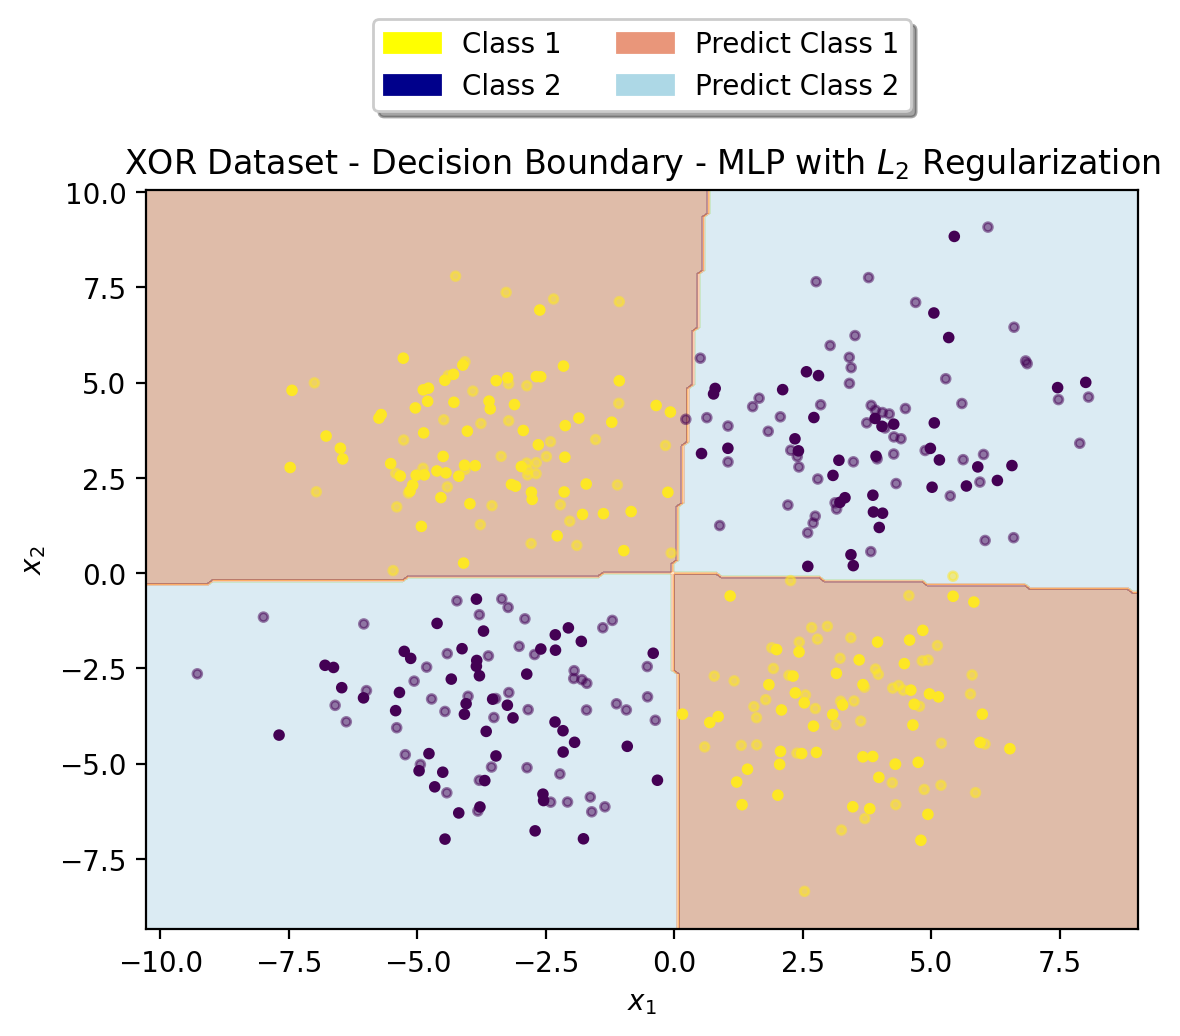

In [78]:
plot_decision_boundary(X_train, X_test, y_train, y_test, model, r"XOR Dataset - Decision Boundary - MLP with $L_2$ Regularization")

In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score

poly = PolynomialFeatures(degree = 2, include_bias = False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

model = LogisticRegression()
model.fit(X_train_poly, y_train.ravel())

y_train_pred = model.predict(X_train_poly)
y_test_pred = model.predict(X_test_poly)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Train Accuracy: ", train_accuracy)
print("Test Accuracy: ", test_accuracy)

Train Accuracy:  1.0
Test Accuracy:  0.99


In [81]:
def plot_decision_boundary(X_train, X_test, y_train, y_test, model, title):
    X = np.concatenate([X_train, X_test], axis = 0)
    y = np.concatenate([y_train, y_test], axis = 0)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    poly = PolynomialFeatures(degree = 2, include_bias = False)
    meshgrid_poly = poly.fit_transform(np.c_[xx.ravel(), yy.ravel()])

    Z = model.predict(meshgrid_poly)

    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap = plt.cm.Paired, alpha=0.4)

    plt.scatter(X_train[:, 0], X_train[:, 1], c = y_train, cmap = "viridis", s = 10)
    plt.scatter(X_test[:, 0], X_test[:, 1], c = y_test, cmap = "viridis", s = 10, alpha = 0.5)

    yellow_patch = mpatches.Patch(color = "yellow", label = "Class 1")
    blue_patch = mpatches.Patch(color = "darkblue", label = "Class 2")
    pink_patch = mpatches.Patch(color = "darksalmon", label = "Predict Class 1")
    lblue_patch = mpatches.Patch(color = "lightblue", label = "Predict Class 2")
    plt.legend(handles = [yellow_patch, blue_patch, pink_patch, lblue_patch], loc = "upper center", bbox_to_anchor = (0.5, 1.25), ncol = 2, fancybox = True, shadow = True)

    plt.title(title)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$")
    plt.show()
    

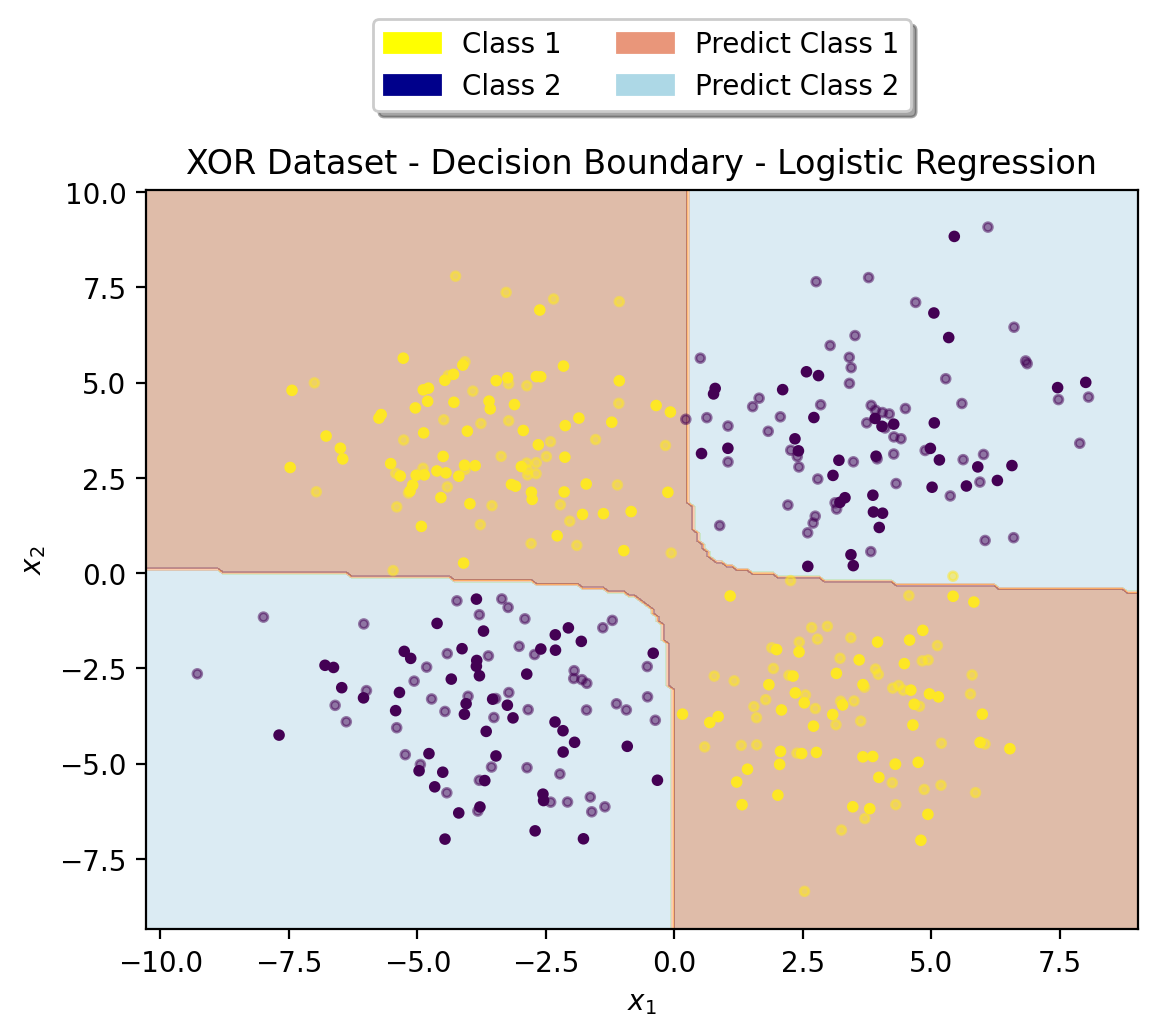

In [83]:
plot_decision_boundary(X_train_poly, X_test_poly, y_train, y_test, model, "XOR Dataset - Decision Boundary - Logistic Regression")

The logistic regression model learns the graph at a slow rate cause it has limited features which are provided by the user whereas the MLP choses the features by itself which helps the model to learn the dataset more precisely.